# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de confusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve as roc_curve_sk
from sklearn.metrics import confusion_matrix as confusion_matrix_sk
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y[Y == 10] = 0
labels = np.unique(Y)
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

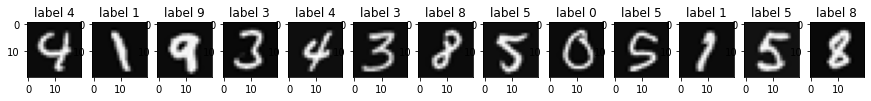

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0]) #pich a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

<del>Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.</del>

Nous avons changer les étiquette 10 en 0.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion

In [6]:
def index_of(array, item):
    return np.where(array == item)

In [7]:
def confusion_matrix(y_true, y_pred, labels=None):
    #On obtient les classes distinctes et leurs nombres
    y_true_no_duplicate = sorted(set(y_true))
    n = len(y_true_no_duplicate)
    #On intialise la matricde de confusion
    matrix = np.zeros((n,n), dtype=np.int32)
    
    for i in range(len(y_true)):
        matrix[y_true_no_duplicate.index(y_true[i])][y_true_no_duplicate.index(y_pred[i])] += 1
    
    return matrix

- Rappel


In [8]:
def recall_scores(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels)
    # TPs de chaque classe sont stoqués dans la première diagonale
    first_diagonal = np.diag(cm)
    # les sommes TPs + FNs pour chaque classe représentent la somme des lignes
    lines_sum = cm.sum(axis=1)
    return np.divide(first_diagonal, 
                     lines_sum, 
                     out = np.zeros(first_diagonal.shape[0]), 
                     where=lines_sum!=0)

- Précision

In [9]:
def precision_scores(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels)
    # TPs de chaque classe sont stoqués dans la première diagonale
    first_diagonal = np.diag(cm)
    # les sommes TPs + FPs pour chaque classe représentent la somme des lignes
    columns_sum = cm.sum(axis=0)
    return np.divide(first_diagonal, 
                     columns_sum, 
                     out = np.zeros(first_diagonal.shape[0]), 
                     where=columns_sum!=0)

- Taux de FP

In [10]:
def fpr_scores(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels)
    first_diagonal = np.diag(cm)
    columns_sum = cm.sum(axis=0)
    # les FPs représentent les sommes des colonnes 
    # moins les TPs qui sont stoqués dans la diagonale
    fps = columns_sum - first_diagonal
    lines_sum = cm.sum(axis=1)
    matrix_sum = cm.sum(axis=(0, 1))
    # les TNs sont calculés par la formule :
    # = somme matrice - TPs - FPs - FNs
    # = somme matrice - (diagonale) - (sommes des colonnes - diagonale) -(sommes des lignes - diagonale)
    # = somme matrice - sommes des colonnes - sommes des lignes + diagonale
    tns = matrix_sum - columns_sum - lines_sum + first_diagonal
    return np.divide(fps, 
                     fps + tns, 
                     out = np.zeros(fps.shape[0]), 
                     where = lines_sum != 0)

- Spécificité

In [11]:
def tnr_scores(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels)
    first_diagonal = np.diag(cm)
    columns_sum = cm.sum(axis=0)
    # les FPs représentent les sommes des colonnes 
    # moins les TPs qui sont stoqués dans la diagonale
    fps = columns_sum - first_diagonal
    lines_sum = cm.sum(axis=1)
    matrix_sum = cm.sum(axis=(0, 1))
    # les TNs sont calculés par la formule :
    # = somme matrice - TPs - FPs - FNs
    # = somme matrice - (diagonale) - (sommes des colonnes - diagonale) -(sommes des lignes - diagonale)
    # = somme matrice - sommes des colonnes - sommes des lignes + diagonale
    tns = matrix_sum - columns_sum - lines_sum + first_diagonal
    return np.divide(tns,
                     fps + tns, 
                     out = np.zeros(tns.shape[0]), 
                     where = lines_sum != 0)

- Courbe ROC

In [12]:
# using one versus the rest strategy
def roc_curve(y_true, y_pred_proba, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred), axis=0))
    else:
        labels = np.asarray(labels)
        
    n_labels = labels.shape[0]
    thrs = np.append(np.arange(0., 1., .05, dtype=np.float32), 2.)
    n_thrs = thrs.shape[0]
    fpr = np.zeros((n_thrs, n_labels), dtype=np.float32)
    tpr = np.zeros((n_thrs, n_labels), dtype=np.float32)
    
    y_pred_binary = np.zeros(y_pred_proba.shape[0], dtype=np.float32)
    y_true_binary = np.zeros(y_true.shape[0], dtype=np.float32)
    
    for i in range(n_labels):
        # binary classification class i vs the other classes
        # for the true labels
        # for positive instances
        y_true_binary[np.where(y_true == labels[i])] = 1
        # for negative instances
        y_true_binary[np.where(y_true != labels[i])] = 0

        for j in range(n_thrs):
            # for the predicted labels
            # for positive instances
            y_pred_binary[np.where(y_pred_proba[:, i] >= thrs[j])] = 1
            # for negative instances
            y_pred_binary[np.where(y_pred_proba[:, i] < thrs[j])] = 0
            
            fpr[j, i] = fpr_scores(y_true_binary, y_pred_binary, labels=[0, 1])[1]
            tpr[j, i] = recall_scores(y_true_binary, y_pred_binary, labels=[0, 1])[1]
            
            
    return fpr, tpr, thrs

### Fonction de test des métriques

In [13]:
# Fonction de test pour calculer toutes les metriques pour une prédicition donnée
def calculate_metrics(y_true, y_pred_proba, labels=labels):
    plt.figure(figsize=(20, 10))
    y_pred = labels[np.argmax(y_pred_proba, axis=1)]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.subplot(1, 2, 1)
    plt.imshow(cm, cmap='gray')
    
    recall = recall_scores(y_true, y_pred, labels=labels).mean()
    precision = precision_scores(y_true, y_pred, labels=labels).mean()
    fpr = fpr_scores(y_true, y_pred, labels=labels).mean()
    tnr = tnr_scores(y_true, y_pred, labels=labels).mean()
    
    fprs, tprs, thrs = roc_curve(y_true, y_pred_proba, labels=labels)
    plt.subplot(1, 2, 2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    for i in range(labels.shape[0]):
        plt.plot(fprs[:, i], tprs[:, i])
        
    print("recall    :", recall)
    print("precision :", precision)
    print("fpr       :", fpr)
    print("tnr       :", tnr)

In [14]:
def sklearn_comparison(y_true, y_pred_proba, labels=labels):
    plt.figure(figsize=(20, 10))
    y_pred = labels[np.argmax(y_pred_proba, axis=1)]
    plt.subplot(1, 2, 1)
    plt.imshow(confusion_matrix_sk(y_true, y_pred), cmap='gray')
    
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(labels.shape[0]):
        fpr[i], tpr[i], thresh[i] = roc_curve_sk(y_true, y_pred_proba[:,i], pos_label=i)
    plt.subplot(1, 2, 2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    for i in range(labels.shape[0]):
        plt.plot(fpr[i], tpr[i])
        
    print("recall    :", recall_score(y_true, y_pred, average=None).mean())
    print("precision :", precision_score(y_true, y_pred, average=None).mean())

In [15]:
def precision_curve(X_train, Y_train, X_test, Y_test, k_range=None):
    if k_range is None:
        k_range = np.arange(3, 20, 2)
    precisions = np.zeros(k_range.shape[0], dtype=np.float32)
    for i, k_ in enumerate(k_range):
        Y_pred = np.asarray([KPP(x, X_train, Y_train, k = k_, return_proba=False) for x in X_test], dtype=np.float32)
        precisions[i] = precision_scores(Y_test, Y_pred).mean()
    plt.xlabel("k")
    plt.ylabel("Precision")
    plt.plot(k_range, precisions)

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [16]:
tRatio=2/3
ttRatio=1/3
# implementer la division
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, test_size=ttRatio, train_size=tRatio, random_state=42)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [17]:
def minkowski_distance(x1, x2, p):
    #return np.math.pow(np.linalg.norm(x1 - x2), p)
    return np.power(np.power(np.absolute(x1 - x2), p).sum(), 1/p)

In [18]:
def KPP(x, X, Y, k = 10, distance="eclidien", return_proba=True):
    if distance == "eclidien":
        p = 1
    else:
        p = 2
    
    k = min(k, len(Y))
    labels = np.unique(Y)
    
    # Il faudra retourner l'etiquette de x, en le comparant à toutes les données de Xt, Yt
    sorted_labels = np.asarray(list(zip(*sorted(zip(X, Y), key=lambda x_y: minkowski_distance(x_y[0], x, p))))[1])
    unique, counts = np.unique(sorted_labels[:k], return_counts=True)
    if not return_proba:
        return unique[np.argmax(counts)] # to return predictions only
    else:
        proba = np.zeros(labels.shape[0])
        for label, count in zip(unique, counts):
            proba[index_of(labels, label)] = count / k;
        return proba

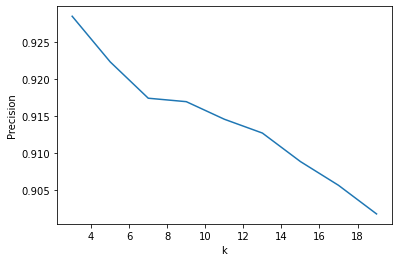

In [19]:
precision_curve(Xt, Yt, Xtt, Ytt)

In [20]:
y_pred_proba = np.asarray([KPP(x, Xt, Yt, k=10) for x in Xtt], dtype=np.float32)

recall    : 0.9073732794669992
precision : 0.9143181475039255
fpr       : 0.010197722511758154
tnr       : 0.9898022774882419


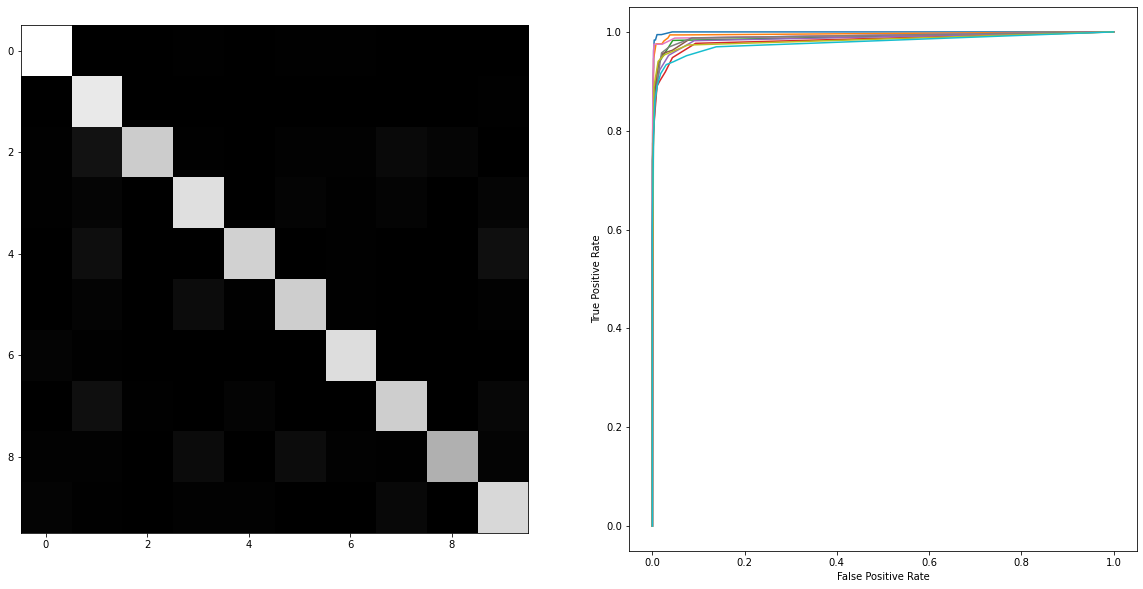

In [21]:
calculate_metrics(Ytt, y_pred_proba)

recall    : 0.9073732794669992
precision : 0.9143181475039255


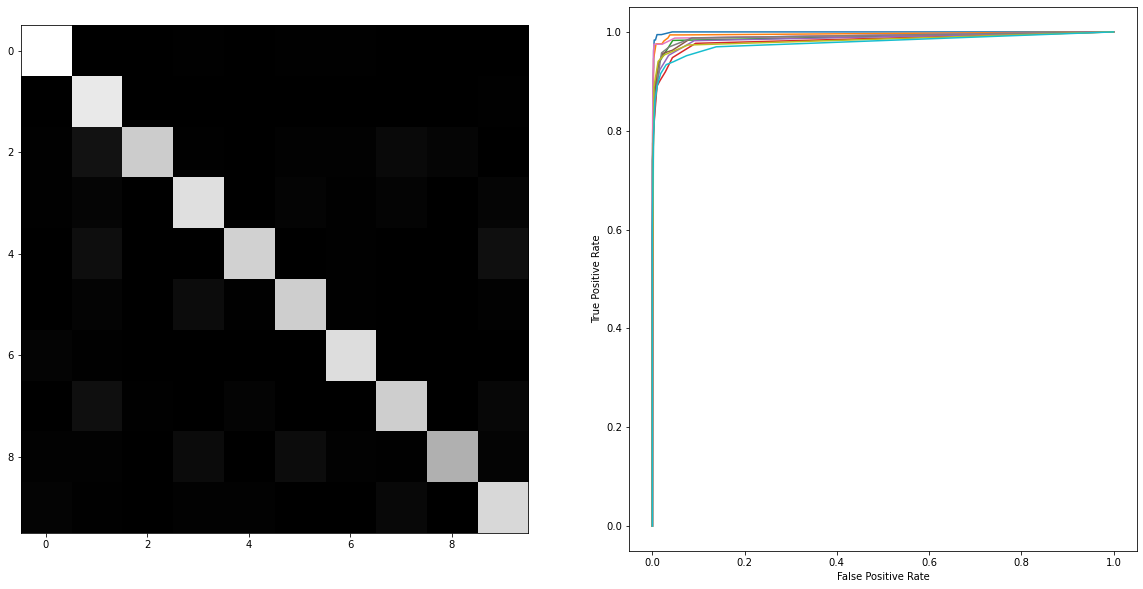

In [22]:
sklearn_comparison(Ytt, y_pred_proba)

# Méthode 1: MVS
Machine à Vecteurs de Support

In [23]:
#Créer le modèle
model= svm.SVC(kernel='linear', probability=True) 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

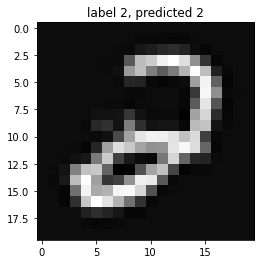

In [24]:
# tester une image
c = 3
y_pred[c]
a = Xtt[c, :].reshape((20, 20))
a = np.transpose(a)
plt.title('label ' + str(Ytt[c]) + ", predicted " + str(y_pred[c]))
plt.imshow(a, cmap='gray')

recall    : 0.9202746544472664
precision : 0.9205731020190264
fpr       : 0.008792794976288824
tnr       : 0.9912072050237113


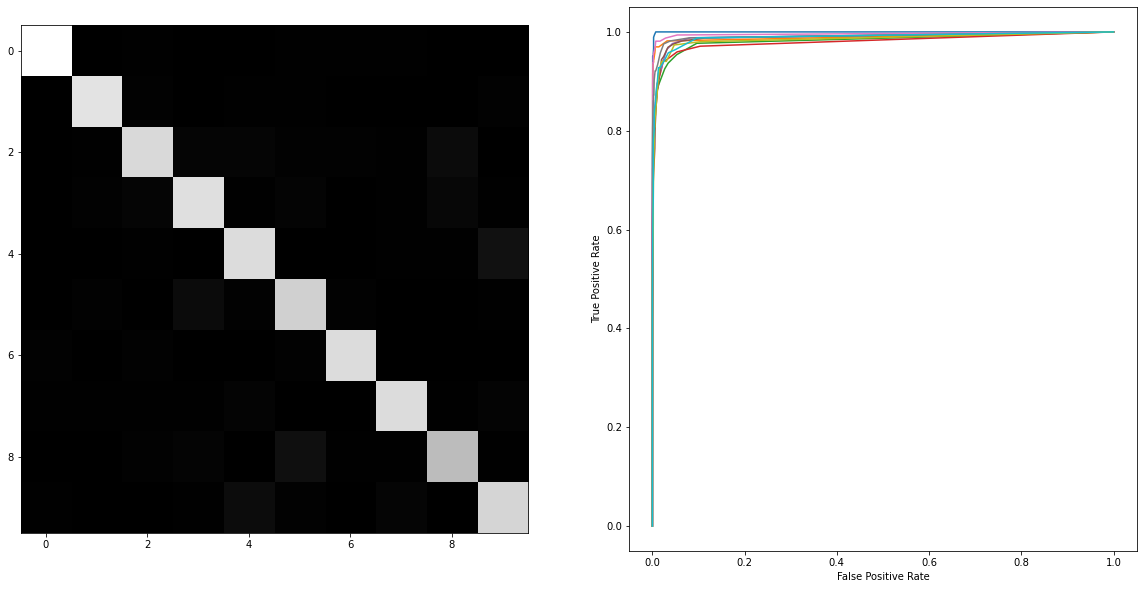

In [25]:
calculate_metrics(Ytt, model.predict_proba(Xtt), labels=labels)

recall    : 0.9202746544472664
precision : 0.9205731020190264


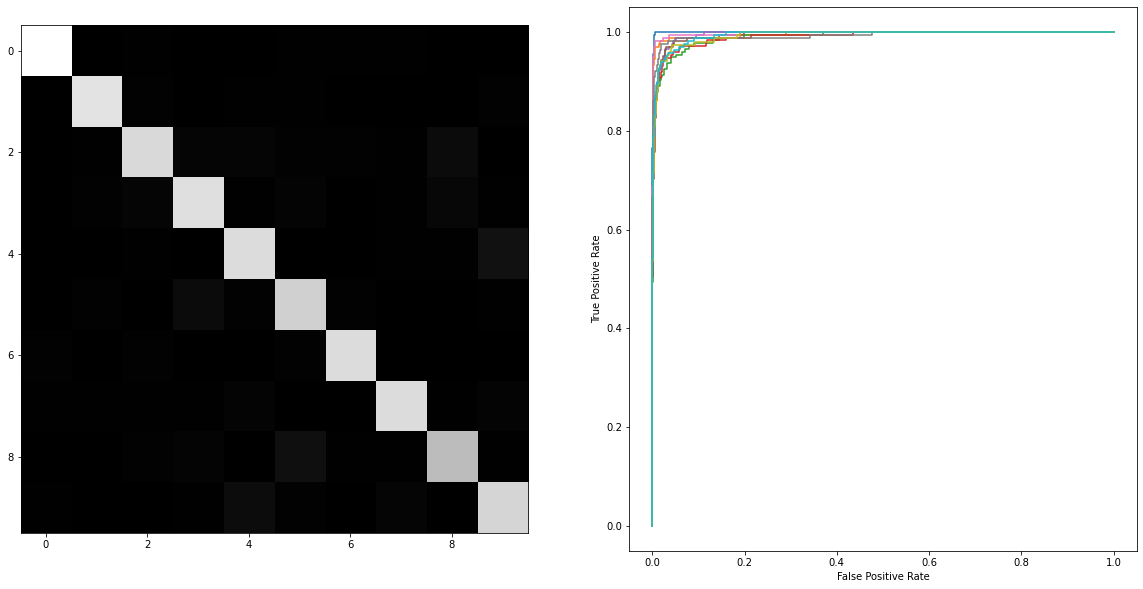

In [26]:
sklearn_comparison(Ytt, model.predict_proba(Xtt))

# Méthode 2: Arbres de décision


In [27]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

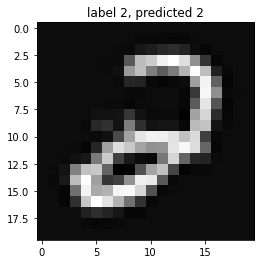

In [28]:
# tester une image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]) + ', predicted ' + str(y_pred[c]))
plt.imshow(a,cmap='gray')

recall    : 0.7461657197744149
precision : 0.7475944703945585
fpr       : 0.02804634168892698
tnr       : 0.971953658311073


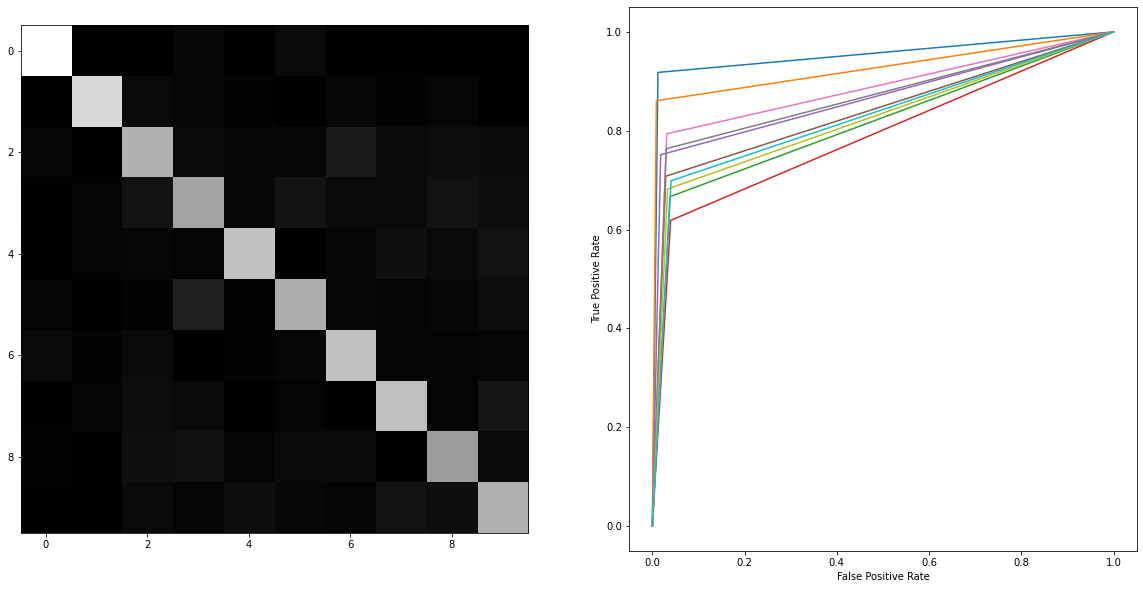

In [29]:
calculate_metrics(Ytt, model.predict_proba(Xtt), labels=labels)

recall    : 0.7461657197744149
precision : 0.7475944703945585


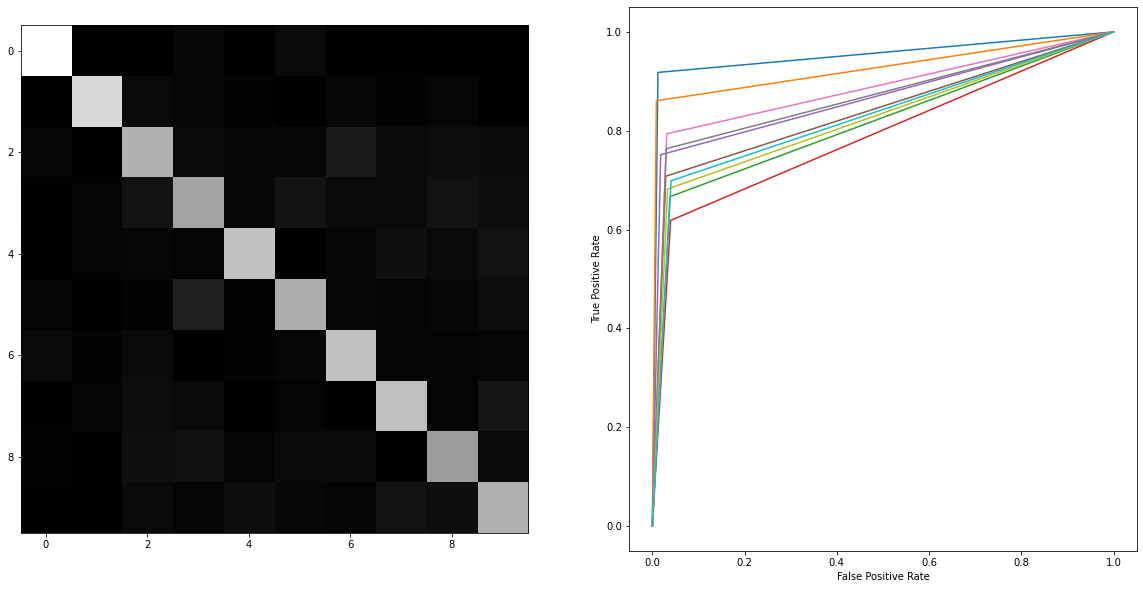

In [30]:
sklearn_comparison(Ytt, model.predict_proba(Xtt))

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [31]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [32]:
# Choisir un image de test 
c=0

In [33]:
model.predict([Xtt[c,:]])

array([0])

In [34]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[1.00000000e+00, 7.28938278e-40, 2.55150326e-57, 1.97382287e-27,
        8.08019551e-56, 4.39692437e-61, 1.18941995e-50, 6.53777047e-77,
        8.23853042e-78, 1.49291792e-33]])

Afficher l'image testée

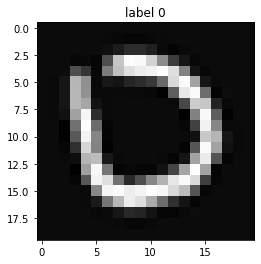

In [35]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

recall    : 0.19180790960451977
precision : 0.10079889267296246
fpr       : 0.08972768674920965
tnr       : 0.9102723132507904


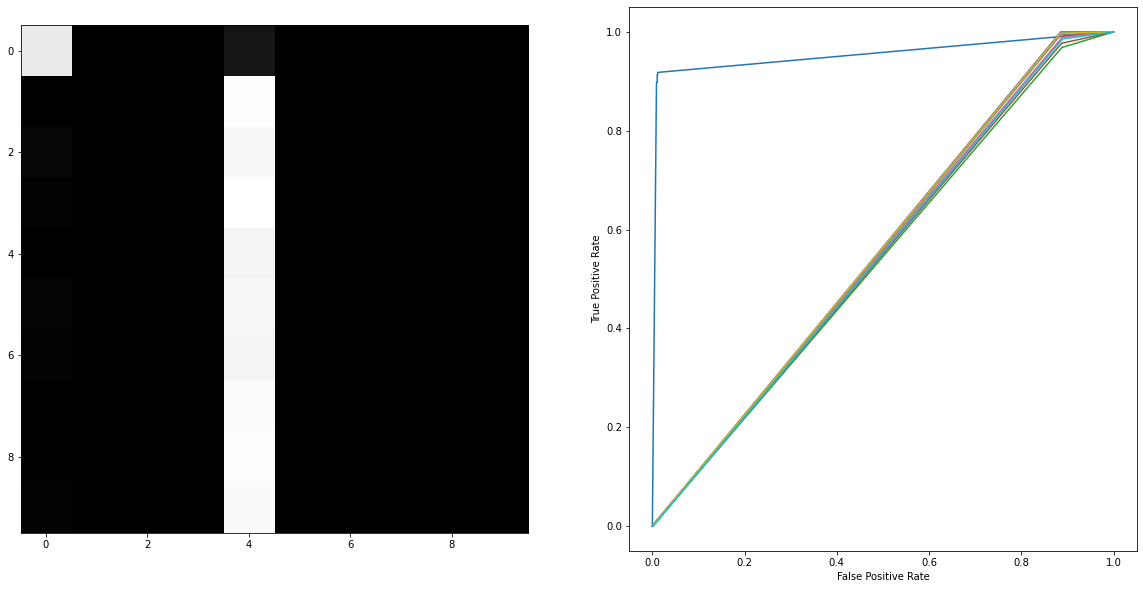

In [36]:
calculate_metrics(Ytt, model.predict_proba(Xtt), labels=labels)

recall    : 0.19180790960451977
precision : 0.10079889267296246


/home/ayoub/miniconda3/envs/tp_ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


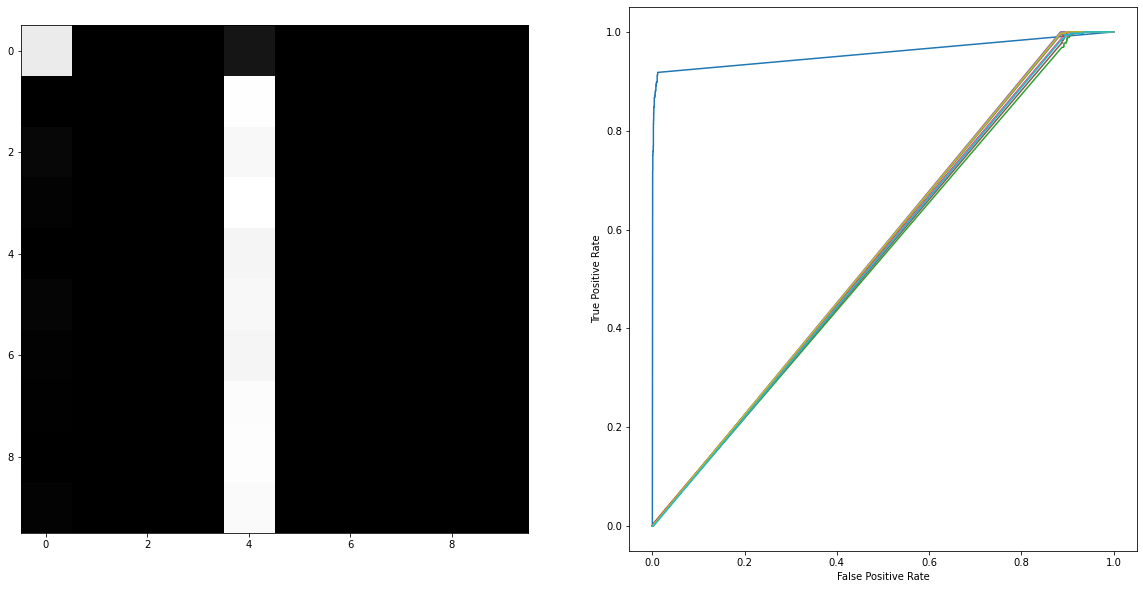

In [37]:
sklearn_comparison(Ytt, model.predict_proba(Xtt))

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [38]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=42, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [39]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# entrainer le modèle
model.fit(Xt_rncN, Yt_rnc, epochs=20)

# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)


2022-03-07 18:45:37.122025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
47/47 [==============================] - 1s 6ms/step - loss: 1.0152 - accuracy: 0.6747
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 0.3574 - accuracy: 0.8940
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.2590 - accuracy: 0.9313
Epoch 4/20
47/47 [==============================] - 0s 6ms/step - loss: 0.2060 - accuracy: 0.9407
Epoch 5/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1628 - accuracy: 0.9553
Epoch 6/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1344 - accuracy: 0.9627
Epoch 7/20
47/47 [==============================] - 0s 6ms/step - loss: 0.1174 - accuracy: 0.9687
Epoch 8/20
47/47 [==============================] - 0s 6ms/step - loss: 0.0779 - accuracy: 0.9840
Epoch 9/20
47/47 [==============================] - 0s 6ms/step - loss: 0.0807 - accuracy: 0.9827
Epoch 10/20
47/47 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.9860
Epoch 11/20
47/47 [

In [40]:
acc

0.9365714192390442

recall    : 0.9369344412610052
precision : 0.9367451212301567
fpr       : 0.007049652028675896
tnr       : 0.992950347971324


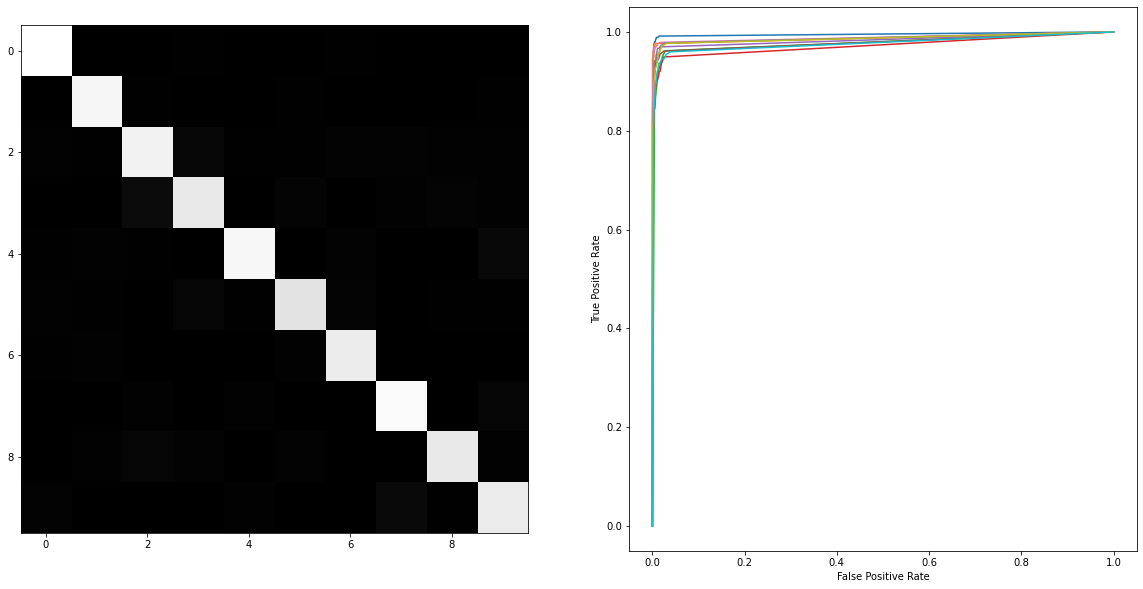

In [41]:
calculate_metrics(Ytt, model.predict(Xtt_rncN), labels=labels)

recall    : 0.9369344412610052
precision : 0.9367451212301567


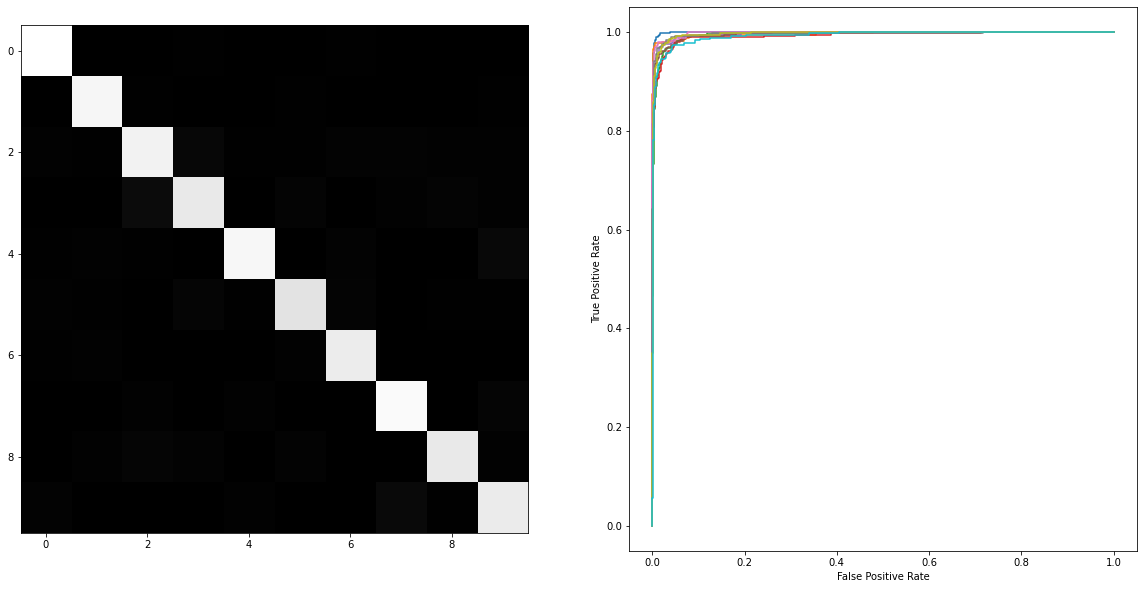

In [42]:
sklearn_comparison(Ytt, model.predict(Xtt_rncN))

# Appliquer les métriques implementées pour voir le résultat

Nous avons testé les métriques sous chaque modèle pour plus de clarté.

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

# bonne chance